In [1]:
# Mounting the drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI

/content/drive/My Drive/Datasets/Healthcare_AI_Datasets/Brain_MRI


In [3]:
# Importing the libraries:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
brain_df=pd.read_csv('data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [7]:
# Getting the MRI scan images having mask=1 or having a brain tumor:
brain_df_mask=brain_df[brain_df['mask']==1]
brain_df_mask.shape
brain_df_mask.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1373 entries, 445 to 3808
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  1373 non-null   object
 1   image_path  1373 non-null   object
 2   mask_path   1373 non-null   object
 3   mask        1373 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 53.6+ KB


In [9]:
# Splitting the dataframe into train and test:
from sklearn.model_selection import train_test_split

X_train, X_val=train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val=train_test_split(X_val, test_size=0.5)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1167, 4)
(103, 4)
(103, 4)


In [13]:
# Creating seperate list for Image ID, class ID to pass into the generator:

train_ids=list(X_train.image_path)
train_mask=list(X_train.mask_path)

val_ids=list(X_val.image_path)
val_mask=list(X_val.mask_path)

In [14]:
# Now in the next step we are using a package from github called-'utilities':

from utilities import DataGenerator

training_generator=DataGenerator(train_ids, train_mask)
validation_generator=DataGenerator(val_ids, val_mask)

In [15]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [16]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [17]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [18]:
model_seg.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
# Training the model:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="Tumor_segmentation_and_localization_weights.hdf5", verbose=1, save_best_only=True)

In [21]:
history = model_seg.fit(training_generator, epochs = 100, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9284
Epoch 00001: val_loss improved from inf to 0.16178, saving model to Tumor_segmentation_and_localization_weights.hdf5
72/72 [==============================] - 712s 10s/step - loss: 0.1971 - accuracy: 0.9284 - val_loss: 0.1618 - val_accuracy: 0.9709
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9807
Epoch 00002: val_loss improved from 0.16178 to 0.06559, saving model to Tumor_segmentation_and_localization_weights.hdf5
72/72 [==============================] - 25s 347ms/step - loss: 0.0599 - accuracy: 0.9807 - val_loss: 0.0656 - val_accuracy: 0.9801
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9825
Epoch 00003: val_loss improved from 0.06559 to 0.05230, saving model to Tumor_segmentation_and_localization_weights.hdf5
72/72 [==============================] - 14s 190ms/step - loss: 0.0516 - accuracy: 0.9825 - v

In [22]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("Tumor_segmentation_and_localization_model.json","w") as json_file:
  json_file.write(model_json)

In [23]:
# loading the segmentation and localization model:
with open('Tumor_segmentation_and_localization_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('Tumor_segmentation_and_localization_weights.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
# loading the classification model:
with open('Brain_Tumor_Detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('Brain_Tumor_Detection_weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])

In [25]:
# Preparing the 'test' class as done in the classification one:
# Dropping the 'patient ID' column:
brain_df_train=brain_df.drop(columns=['patient_id'])
brain_df_train.shape 

(3929, 3)

In [26]:
brain_df_train['mask']=brain_df_train['mask'].apply(lambda x: str(x))

In [27]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [28]:
# Splitting the data into train, and test:
from sklearn.model_selection import train_test_split

train, test=train_test_split(brain_df_train, test_size=0.15)

In [32]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, actual_mask = prediction(test, model, model_seg)

In [33]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'actual_mask': actual_mask})
df_pred

,image_path,predicted_mask,actual_mask
0,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38...,"[[[[3.718298e-05], [6.648078e-05], [5.050851e-...",1
1,TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_10...,No mask,0
2,TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17...,"[[[[4.837913e-05], [9.8143384e-05], [8.037162e...",1
3,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_4.tif,No mask,0
4,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_35...,"[[[[4.0720817e-05], [7.227143e-05], [5.338798e...",1
...,...,...,...
585,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_30...,No mask,0
586,TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_33...,No mask,0
587,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_37...,No mask,0
588,TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_16...,"[[[[3.1250333e-05], [0.00011947], [0.00017474]...",1


In [34]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,actual_mask
0,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38...,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38...,1,"[[[[3.718298e-05], [6.648078e-05], [5.050851e-...",1
1,TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_10...,TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_10...,0,No mask,0
2,TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17...,TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_17...,1,"[[[[4.837913e-05], [9.8143384e-05], [8.037162e...",1
3,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_4.tif,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_4_...,0,No mask,0
4,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_35...,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_35...,1,"[[[[4.0720817e-05], [7.227143e-05], [5.338798e...",1


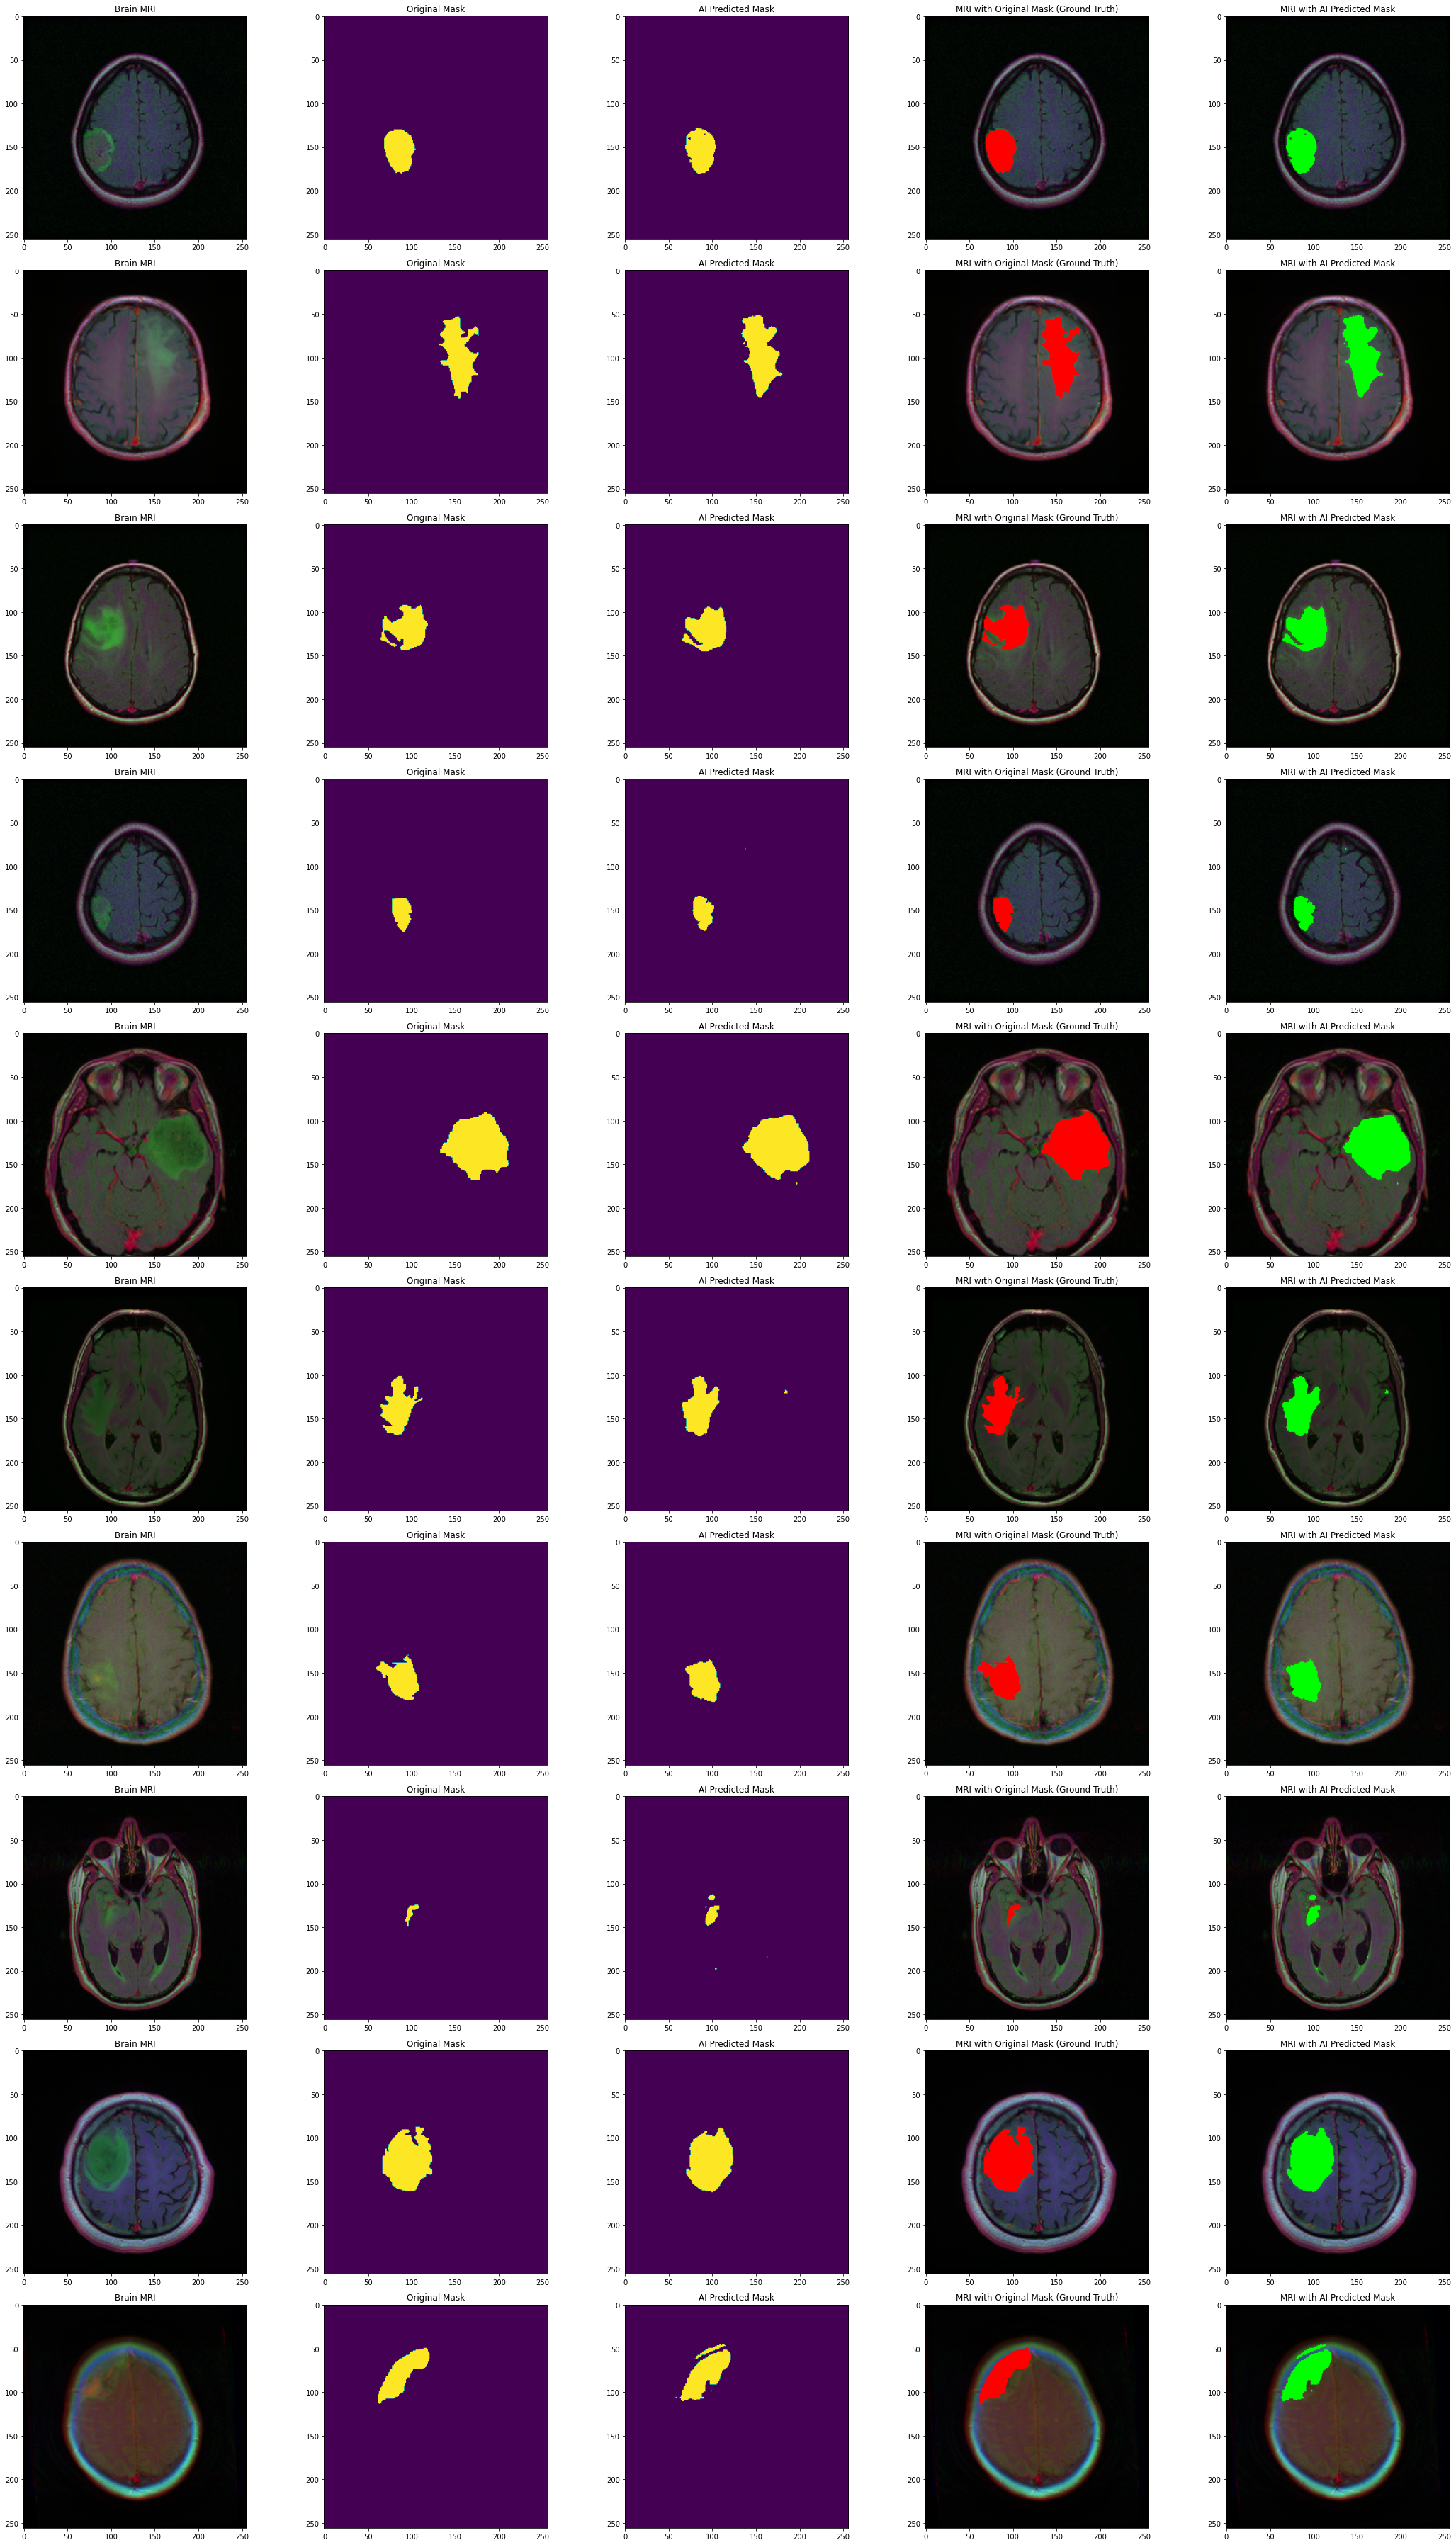

In [36]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['actual_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()